# Mini Projeto MLP

## MNIST Loader

In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [3]:
training_data, validation_data, test_data = load_data_wrapper()
training_data = list(training_data)
test_data = list(test_data)

## Network

In [4]:
"""
A module to implement the stochastic gradient descent learning
algorithm for a feedforward neural network.  Gradients are calculated
using backpropagation.  Note that I have focused on making the code
simple, easily readable, and easily modifiable.  It is not optimized,
and omits many desirable features.
"""

#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes, activationFunc):
        """The list `sizes` contains the number of neurons in the respective layers of the network. 
        The biases and weights for the network are initialized randomly, using a Gaussian distribution with mean 0, and variance 1.  
        First Layer is assumed to be an input layer and by convention we won't set any biases for those neurons, since biases are only ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]
        self.activation = self.activationFunction(activationFunc)
        self.deriv = self.derivativeFunction(activationFunc)

    def activationFunction(self, functionName):
      if functionName == 'sigmoid':
        return lambda x: x
      elif functionName == 'relu':
        return lambda x: x

    def derivativeFunction(self, functionName):
      if functionName == 'sigmoid':
        return lambda x: x
      elif functionName == 'relu':
        return lambda x: x

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def fit(self, training_data, epochs, mini_batch_size, learning_rate, test_data=None):
        """Train the neural network using mini-batch stochastic gradient descent.  
        The `training_data` is a list of tuples (x, y) representing the training inputs and the desired outputs."""
        training_data = list(training_data)
        n = len(training_data)
        acc = []
        best_acc = 0
        if test_data:
            test_data = list(test_data)
            n_test = len(test_data)

        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[k : k + mini_batch_size] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, learning_rate)
            
            eval = self.evaluate(test_data)
            acc.append(eval /  n_test)
            if (eval /  n_test) > best_acc:
              best_acc = (eval /  n_test)

            if test_data:
                print("Epoch {} : {} / {}".format(j, eval, n_test))
            else:
                print("Epoch {} complete".format(j))
        
        return best_acc, acc

    def update_mini_batch(self, mini_batch, learning_rate):
        """Update the network's weights and biases by applying gradient descent using backpropagation to a single mini batch.
        The `mini_batch` is a list of tuples ``(x, y)``, and ``eta`` is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w - (learning_rate/len(mini_batch))*nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (learning_rate/len(mini_batch))*nb for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the gradient for the cost function C_x.  
        ``nabla_b`` and ``nabla_w`` are layer-by-layer lists of numpy arrays, similar to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural network outputs the correct result. 
        Note that the neural network's output is assumed to be the index of whichever neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
# def accuracy_score(y_true, y_pred):

def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

In [5]:
net = Network([784, 30, 10], 'sigmoid')
best_acc, acc = net.fit(training_data, 10, 10, 3.0, test_data=test_data)

Epoch 0 : 9126 / 10000
Epoch 1 : 9252 / 10000
Epoch 2 : 9334 / 10000
Epoch 3 : 9375 / 10000
Epoch 4 : 9422 / 10000
Epoch 5 : 9394 / 10000
Epoch 6 : 9434 / 10000
Epoch 7 : 9437 / 10000
Epoch 8 : 9457 / 10000
Epoch 9 : 9477 / 10000


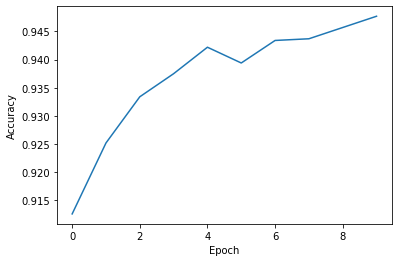

In [14]:
plt.plot(acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

In [9]:
best_acc

0.9477

## Grid Search

In [10]:
sizes = [4, 16, 64, 256]
learning_rates = [0.25, 0.5, 0.75]
activation_functions = ['sigmoid']
learning_algorithms = []
drop_out = []